# Whiteboard Test

Trying to understand the difference between defining the system based on EKE and MKE

In [1]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo
import xrft
import pandas as pd
import scipy.ndimage as filter


import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf

In [2]:
reload(df)
reload(ef)
reload(ff)
reload(pf);

In [3]:
float_z = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_z.nc')
float_r = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_rho.nc')

In [7]:
l1 = 100
l2 = 200
l3 = 400
n = 100

MKE1 = ef.get_MV(float_z,l1,variable='SPICE')
MKE2 = ef.get_MV(float_z,l2,variable='SPICE')
MKE3 = ef.get_MV(float_z,l3,variable='SPICE')

EKE1 = ef.get_EV(float_z,l1,variable='SPICE')
EKE2 = ef.get_EV(float_z,l2,variable='SPICE')
EKE3 = ef.get_EV(float_z,l3,variable='SPICE')

In [8]:
MKE0_v = EKE1
MKE1_v = MKE1 - MKE2
MKE2_v = MKE2 - MKE3
MKE3_v = MKE3

EKE0_v = EKE1
EKE1_v = EKE2 - EKE1
EKE2_v = EKE3 - EKE2
EKE3_v = MKE3

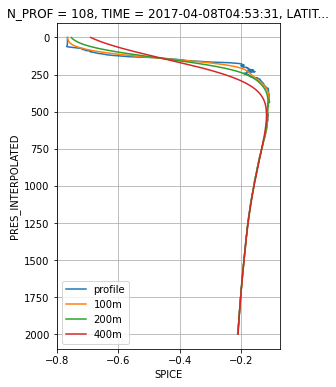

In [9]:
plt.figure(figsize=(4,6))

float_z.isel(N_PROF=n).SPICE.plot(y='PRES_INTERPOLATED',label='profile')
plt.plot(ff.get_filt_prof(float_z.isel(N_PROF=n).SPICE,l1),float_z.PRES_INTERPOLATED,label='{}m'.format(l1))
plt.plot(ff.get_filt_prof(float_z.isel(N_PROF=n).SPICE,l2),float_z.PRES_INTERPOLATED,label='{}m'.format(l2))
plt.plot(ff.get_filt_prof(float_z.isel(N_PROF=n).SPICE,l3),float_z.PRES_INTERPOLATED,label='{}m'.format(l3))

plt.gca().invert_yaxis()
plt.legend()
plt.grid()

plt.savefig('profiles')

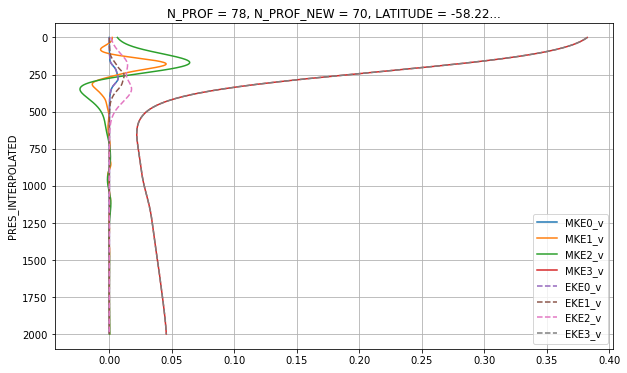

In [10]:
n = 70
plt.figure(figsize=(10,6))
MKE0_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='MKE0_v')
MKE1_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='MKE1_v')
MKE2_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='MKE2_v')
MKE3_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='MKE3_v')

EKE0_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE0_v')
EKE1_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE1_v')
EKE2_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE2_v')
EKE3_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE3_v')

plt.gca().invert_yaxis()
plt.legend()
plt.grid()

plt.savefig('EKE,MKE')

This could be something that never came up in Stenberg because SSH is more constant, less sharp changes

## do cross terms cancel in EKE? I'd be forever grateful if they did :)

$MKE =         + <<u>>^2            + 2<<u>u'>          + <u'>^2$
$EKE = <<u>^2> - <<u>>^2 + <2<u>u'> - 2<<u>u'> + <u'^2> - <u'>^2$

$u = <u> + u'$

In [16]:
l1 = 2.
l2 = 3.

In [43]:
y = np.linspace(0,10*np.pi)
u = np.sin(y) + np.sin(y/3 + np.pi/9)

In [44]:
u_filt_l1 = filter.gaussian_filter1d(u, l1, mode='nearest')
u_filt_l2 = filter.gaussian_filter1d(u, l2, mode='nearest')

In [45]:
u_anom_l1 = u - u_filt_l1
u_anom_l2 = u - u_filt_l2

Text(0.5, 0, 'tracer values')

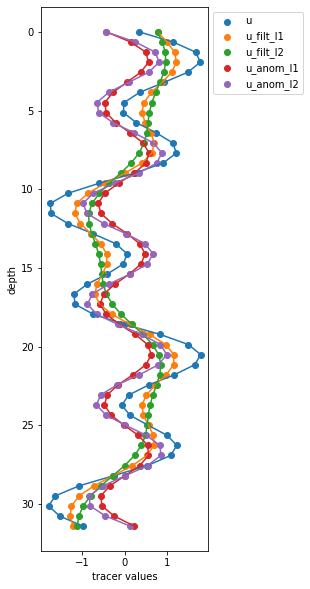

In [54]:
plt.figure(figsize=(3,10))
plt.scatter(u,y,label='u')
plt.scatter(u_filt_l1,y,label='u_filt_l1')
plt.scatter(u_filt_l2,y,label='u_filt_l2')
plt.scatter(u_anom_l1,y,label='u_anom_l1')
plt.scatter(u_anom_l2,y,label='u_anom_l2')
plt.plot(u,y)
plt.plot(u_filt_l1,y)
plt.plot(u_filt_l2,y)
plt.plot(u_anom_l1,y)
plt.plot(u_anom_l2,y)
plt.legend(bbox_to_anchor=(1,1))
plt.gca().invert_yaxis()
plt.ylabel('depth')
plt.xlabel('tracer values')

In [47]:
MKE_1 = filter.gaussian_filter1d(u, l1, mode='nearest')**2
EKE_1 = filter.gaussian_filter1d(u**2, l1, mode='nearest') - MKE_1

In [48]:
MKE_2 = filter.gaussian_filter1d((u_filt_l1 + u_anom_l1),l1,mode='nearest')**2
EKE_2 = filter.gaussian_filter1d((u_filt_l1 + u_anom_l1)**2,l1,mode='nearest') - MKE_2

In [68]:
term_1 = filter.gaussian_filter1d(u_filt_l1**2,         l1,mode='nearest')
term_2 = filter.gaussian_filter1d(u_filt_l1,            l1,mode='nearest')**2
term_3 = filter.gaussian_filter1d(2*u_filt_l1,l1,mode='nearest')*filter.gaussian_filter1d(u_anom_l1,l1,mode='nearest')
term_4 = filter.gaussian_filter1d(u_filt_l1,            l1,mode='nearest')*2.*filter.gaussian_filter1d(u_anom_l1,  l1,mode='nearest')
term_5 = filter.gaussian_filter1d(u_anom_l1**2,         l1,mode='nearest')
term_6 = filter.gaussian_filter1d(u_anom_l1,            l1,mode='nearest')**2

In [69]:
MKE_3 =          term_2          + term_4          + term_6
EKE_3 = term_1 - term_2 + term_3 - term_4 + term_5 - term_6

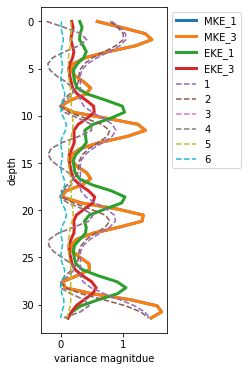

In [70]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.plot(MKE_1,y,label='MKE_1',linewidth='3')
plt.plot(MKE_3,y,label='MKE_3',linewidth='3')
plt.plot(EKE_1,y,label='EKE_1',linewidth='3')
plt.plot(EKE_3,y,label='EKE_3',linewidth='3')
plt.plot(term_1,y,'--',label='1')
plt.plot(term_2,y,'--',label='2')
plt.plot(term_3,y,'--',label='3')
plt.plot(term_4,y,'--',label='4')
plt.plot(term_5,y,'--',label='5')
plt.plot(term_6,y,'--',label='6')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('depth')
plt.xlabel('variance magnitdue')
plt.gca().invert_yaxis()

#plt.subplot(1,2,2)
#plt.plot(term_3,y,'--',label='3',color='tab:purple')
#plt.plot(term_4,y,'--',label='4',color='tab:brown')
#plt.gca().invert_yaxis()

plt.subplots_adjust(wspace=0.65)

In [57]:
EKE_1 - EKE_3

array([-5.55111512e-17,  2.22044605e-16, -1.11022302e-16, -1.66533454e-16,
        5.55111512e-17, -1.66533454e-16, -5.55111512e-17,  0.00000000e+00,
       -2.77555756e-17,  0.00000000e+00,  1.94289029e-16,  0.00000000e+00,
        5.55111512e-17,  1.11022302e-16,  1.11022302e-16,  0.00000000e+00,
       -3.33066907e-16, -1.11022302e-16, -1.66533454e-16,  4.99600361e-16,
       -2.77555756e-16,  0.00000000e+00,  8.32667268e-17, -1.11022302e-16,
       -1.94289029e-16, -1.66533454e-16,  5.55111512e-17, -2.22044605e-16,
        1.11022302e-16,  0.00000000e+00,  0.00000000e+00,  1.11022302e-16,
        0.00000000e+00,  0.00000000e+00, -5.55111512e-17,  5.55111512e-17,
        1.11022302e-16, -8.32667268e-17,  1.38777878e-16, -1.66533454e-16,
        0.00000000e+00,  5.55111512e-17,  1.11022302e-16,  2.22044605e-16,
        0.00000000e+00, -3.33066907e-16,  2.22044605e-16, -4.44089210e-16,
        2.77555756e-16, -2.63677968e-16])

In [19]:
term1  = filter.gaussian_filter1d(u_filt_l2**2, l2,          mode='nearest')
term2  = filter.gaussian_filter1d(u_filt_l1**2, l1,          mode='nearest')
term3  = filter.gaussian_filter1d(u_filt_l2, l2,             mode='nearest')**2
term4  = filter.gaussian_filter1d(u_filt_l1, l1,             mode='nearest')**2

term5  = filter.gaussian_filter1d(2*u_filt_l2*u_anom_l2, l2, mode='nearest')
term6  = filter.gaussian_filter1d(2*u_filt_l1*u_anom_l1, l1, mode='nearest')
term7  = filter.gaussian_filter1d(u_filt_l2*u_anom_l2, l2,   mode='nearest')*2
term8  = filter.gaussian_filter1d(u_filt_l1*u_anom_l1, l1,   mode='nearest')*2

term9  = filter.gaussian_filter1d(u_anom_l2**2, l2,          mode='nearest')
term10 = filter.gaussian_filter1d(u_anom_l1**2, l1,          mode='nearest')
term11 = filter.gaussian_filter1d(u_anom_l2, l2,             mode='nearest')**2
term12 = filter.gaussian_filter1d(u_anom_l1, l1,             mode='nearest')**2

EKE0 =      - term2          + term4         + term6         - term8         + term10          - term12

MKE1 =               - term3 + term4                 - term7 + term8                  - term11 + term12
EKE1 = term1 - term2 - term3 + term4 + term5 - term6 - term7 + term8 + term9 - term10 - term11 + term12

MKE2 =               + term3                         + term7                          + term11

Text(0.5, 1.0, 'MKE2')

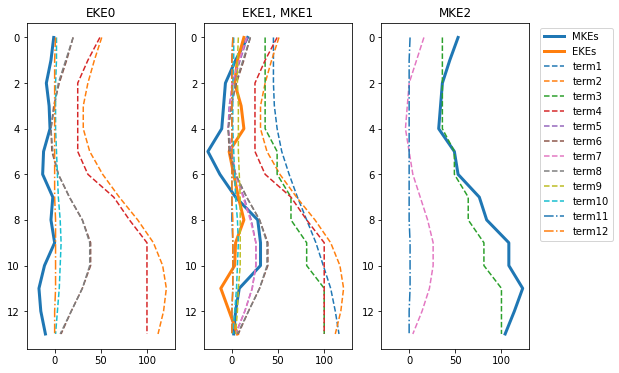

In [20]:
plt.figure(figsize=(9,6))

plt.subplot(1,3,1)
plt.plot(EKE0,y,label='EKE0',linewidth='3')
plt.plot(term2,y,'--',label='term2',color='tab:orange')
plt.plot(term4,y,'--',label='term4',color='tab:red')
plt.plot(term6,y,'--',label='term6',color='tab:brown')
plt.plot(term8,y,'--',label='term8',color='tab:gray')
plt.plot(term10,y,'--',label='term10',color='tab:cyan')
plt.plot(term12,y,linestyle='dashdot',label='term12',color='tab:orange')
plt.xlim(-30,130)
plt.gca().invert_yaxis()
plt.title('EKE0')

plt.subplot(1,3,2)
plt.plot(MKE1,y,label='MKEs',linewidth='3')
plt.plot(EKE1,y,label='EKEs',linewidth='3')
plt.plot(term1,y,'--',label='term1',color='tab:blue')
plt.plot(term2,y,'--',label='term2',color='tab:orange')
plt.plot(term3,y,'--',label='term3',color='tab:green')
plt.plot(term4,y,'--',label='term4',color='tab:red')
plt.plot(term5,y,'--',label='term5',color='tab:purple')
plt.plot(term6,y,'--',label='term6',color='tab:brown')
plt.plot(term7,y,'--',label='term7',color='tab:pink')
plt.plot(term8,y,'--',label='term8',color='tab:gray')
plt.plot(term9,y,'--',label='term9',color='tab:olive')
plt.plot(term10,y,'--',label='term10',color='tab:cyan')
plt.plot(term11,y,linestyle='dashdot',label='term11',color='tab:blue')
plt.plot(term12,y,linestyle='dashdot',label='term12',color='tab:orange')
plt.legend(bbox_to_anchor=(2.8,1))
plt.xlim(-30,130)
plt.gca().invert_yaxis()
plt.title('EKE1, MKE1')

plt.subplot(1,3,3)
plt.plot(MKE2,y,label='MKE2',linewidth='3')
plt.plot(term3,y,'--',label='term3',color='tab:green')
plt.plot(term7,y,'--',label='term7',color='tab:pink')
plt.plot(term11,y,linestyle='dashdot',label='term11',color='tab:blue')
plt.xlim(-30,130)
plt.gca().invert_yaxis()
plt.title('MKE2')
